In [2]:
import os
os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
import segmentation_models_pytorch as smp
import torch
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from segmentation_utils.dataloader import ImageDataset
from segmentation_utils.train_unet import train

/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.getenv('CUDA_LAUNCH_BLOCKING')

In [4]:
main_data_pth = Path('/home/tsakalis/ntua/phd/cellforge/cellforge/data/BlastsOnline/BlastsOnline')

In [5]:
ICM = "GT_ICM"
ZP = "GT_ZP"
TE = "GT_TE"

In [6]:
images_pth = main_data_pth / "Images"

In [7]:
images_pth / ICM

PosixPath('/home/tsakalis/ntua/phd/cellforge/cellforge/data/BlastsOnline/BlastsOnline/Images/GT_ICM')

In [8]:
image_ids = [
    str(pth).split('/')[-1][:-4] for pth in list(images_pth.glob('*.BMP'))
]

In [9]:
images, masks = [], []
for image_id in image_ids:

    img = PIL.Image.open(main_data_pth / f"Images/{image_id}.BMP")
    msk_icm = PIL.Image.open(main_data_pth / f"{ICM}/{image_id} ICM_Mask.bmp")
    msk_zp = PIL.Image.open(main_data_pth / f"{ZP}/{image_id} ZP_Mask.bmp")
    msk_te = PIL.Image.open(main_data_pth / f"{TE}/{image_id} TE_Mask.bmp")

    shape = np.array(img).shape[:2]

    max_dim = np.argmax(shape)         # 0 for rows, 1 for columns
    min_dim = 1 - max_dim              # the other dimension
    delta = shape[max_dim] - shape[min_dim]
    clip = delta // 2                  

    
    msk = np.zeros(shape)

    msk[np.array(msk_icm)==255.] = 1
    msk[np.array(msk_zp)==255.] = 2
    msk[np.array(msk_te)==255.] = 3
    if max_dim == 0:
        # Clip rows
        msk_clipped = msk[clip:clip + shape[min_dim], :]
        img_clipped = np.array(img)[:, clip:clip + shape[min_dim]]
    else:
        # Clip columns
        msk_clipped = msk[:, clip:clip + shape[min_dim]]
        img_clipped = np.array(img)[:, clip:clip + shape[min_dim]]


    images.append(PIL.Image.fromarray(img_clipped))
    masks.append(PIL.Image.fromarray(msk_clipped))
    

In [10]:

msk_clipped.shape

(388, 388)

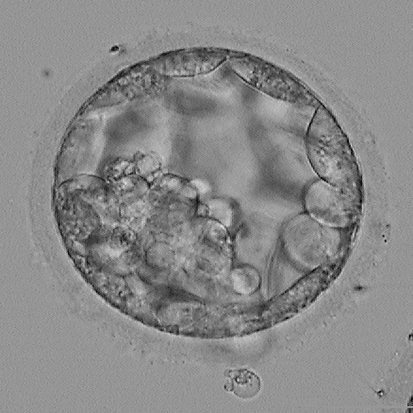

In [11]:
images[1]

In [12]:
np.zeros((np.array(img).shape)).shape

(388, 465)

In [13]:
PIL.Image.fromarray(msk)

<PIL.Image.Image image mode=F size=465x388>

In [14]:

device = 'cuda'
type_of_problem = "multiclass"
model = smp.Unet(
        encoder_name="resnet152",
        encoder_weights="imagenet",
        in_channels=3,
        classes=2,
    )
model.to(device)
lr = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 100

In [15]:

train_dataset =  ImageDataset(images=images[:200], masks=masks[:200], problem_type=type_of_problem)


val_dataset =  ImageDataset(images=images[200:], masks=masks[200:], problem_type=type_of_problem)

In [16]:

img,msk = train_dataset[0]

In [17]:
msk.min()

tensor(-0.2322)

In [18]:
from segmentation_models_pytorch.losses import DiceLoss

loss_fn = DiceLoss(mode=type_of_problem, log_loss=True, from_logits=True)

In [19]:
train(
    train_dataset,
    val_dataset,
    task_name='zp_icm',
    n_epochs =10,
    lr=lr,
    batch_size=32,
    model=model,
    loss_fn=loss_fn

)

Training...:   0%|          | 0/7 [00:00<?, ?it/s]

tensor(-0.3694)
tensor(0)


RuntimeError: one_hot is only applicable to index tensor of type LongTensor.

In [ ]:

torch.Tensor([1]).long()

tensor([1])